# Variational Quantum Eigensolver (VQE)

A variational quantum eigensolver is a variational quantum algorithm where a parametrized quantum circuit is trained to prepare the ground state of a target Hamiltonian [See A. Peruzzo et al. - 2013](https://arxiv.org/abs/1304.3061).

<img src="./figures/vqe.png" width="800" height="500" alt="My Image">

As sketched above, the idea is that we get a state from a quantum circuit, and this state depends on the parameters of the circuit. Then we implement a machine learning routine to update the parameters of the circuit such that the expectation value of our target Hamiltonian on this state is minimized.

<div style="background-color: rgba(255, 105, 105, 0.3); border: 2.5px solid #000000; padding: 15px;">
    <strong>Exercise:</strong> 
    Solve the Grover problem using a VQE. Suppose that you want to find the $i$-th item in a database of $2^n$ items. To do that you have to formulate the problem as an energy minimization problem: you first define an Hamiltonian which encodes in its ground state the $i$-th item you are interested in, then you train your QML model to miminize the expectation value of such Hamiltonian.
    
</div>

In [1]:
from qibo import set_backend
import torch

torch.set_default_dtype(torch.float64)
dev = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# the pytorch backend is recommended for the best performance
set_backend("qiboml", platform="pytorch")


[Qibo 0.2.21|INFO|2025-07-24 13:26:24]: Using qiboml (pytorch) backend on cpu


### Problem's Hamiltonian
First you'll have to come up with the Hamiltonian form that solves the problem, i.e. that encodes the i-th item in its ground state. 
You can use ``qibo``'s ``SymbolicHamiltonian`` and symbols to define the form of your Grover's Hamiltonian.

In [2]:
from qibo.hamiltonians import SymbolicHamiltonian
from qibo.symbols import Z, I

# this creates a Z0 * I1 operator, i.e. a tensor product between a pauli Z
# on the first qubit and the identity on the second qubit
form = Z(0) * I(1)
# you can also add other terms
form += 1 - Z(2) * (1 + I(0) * Z(1) * Z(2))
H = SymbolicHamiltonian(form, nqubits=3)
H.form

1 + Z0*I1 - Z2*(1 + I0*Z1*Z2)

**hint 1:** 

<details>
<summary> show </summary>
If you represent items in the database as bitstrings, then supposing the item you're looking for corresponds to the state with $| x^\ast \rangle = | x_0x_1 ... x_n \rangle$, you may want to write the projector onto that state.
</details>

**hint 2:** 

<details>
<summary> show </summary>
The projector you need is therefore $| x^\ast \rangle \langle x^\ast|$ and you can build the hamiltonian as: 
    $$H = 1 - | x^\ast \rangle \langle x^\ast |$$ 
which, since $x^\ast$ is a string of bits, can be written in terms of $Z$ pauli operators as:
    $$H = 1 - \bigotimes_i \bigg( 1 + (-1)^{x_i} Z_i \bigg)$$
where the $x_i$ are the bits composing $x^\ast$.
</details>

In [3]:
# item to find
item_index = 11 
# database dimension
n_items = 32
# how many qubits do we need?
# use the minimum number of qubits possible!
nqubits = 5

# define a function that takes item_index and n_items
# as inputs and produces the Grover Hamiltonian
import numpy as np

def grover_hamiltonian(item_index: int, n_items: int) -> SymbolicHamiltonian:
    # extract how many qubits you need
    nqubits = (n_items - 1).bit_length()
    # build the binary representation
    bitstring = f"{item_index:0{nqubits}b}"
    bits = [int(b) for b in bitstring]
    # projector onto the desired state
    form = 1 - np.prod([(1 + (-1)**bits[q] * Z(q) ) for q in range(nqubits)])
    return SymbolicHamiltonian(form, nqubits=nqubits)

H = grover_hamiltonian(item_index, n_items)

### Build the QML model and train it!

Now that we have the Hamiltonian, you can build the desired QML model using the tools introduced in the previous notebook. You can always use the ``HardwareEfficient`` ansatz to build the core of your model if you like, or you can come up with your custom parametrized circuit, but do you actually need any encoder in this case?

Epoch 0: Energy = 0.7466289199868741
Epoch 1: Energy = 0.23538663904970136
Epoch 2: Energy = -0.5794923262782505
Epoch 3: Energy = -1.6440672259271025
Epoch 4: Energy = -2.8771040880595233
Epoch 5: Energy = -4.204619911063046
Epoch 6: Energy = -5.51900991208451
Epoch 7: Energy = -6.673904268292004
Epoch 8: Energy = -7.7089136215654035
Epoch 9: Energy = -8.695572153524683
Epoch 10: Energy = -9.700559368247308
Epoch 11: Energy = -10.793016450400067
Epoch 12: Energy = -12.004176225053085
Epoch 13: Energy = -13.377594421412299
Epoch 14: Energy = -14.947546670289102
Epoch 15: Energy = -16.692209167568937
Epoch 16: Energy = -18.54365335707153
Epoch 17: Energy = -20.405678988779275
Epoch 18: Energy = -22.2563758046511
Epoch 19: Energy = -24.17647776128652

 -> We were looking for item: 01011


(<Axes: xlabel='States', ylabel='Probabilities'>,
 <Figure size 750x500 with 1 Axes>)

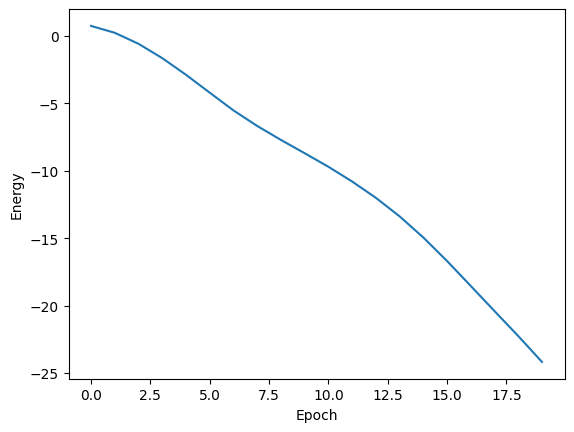

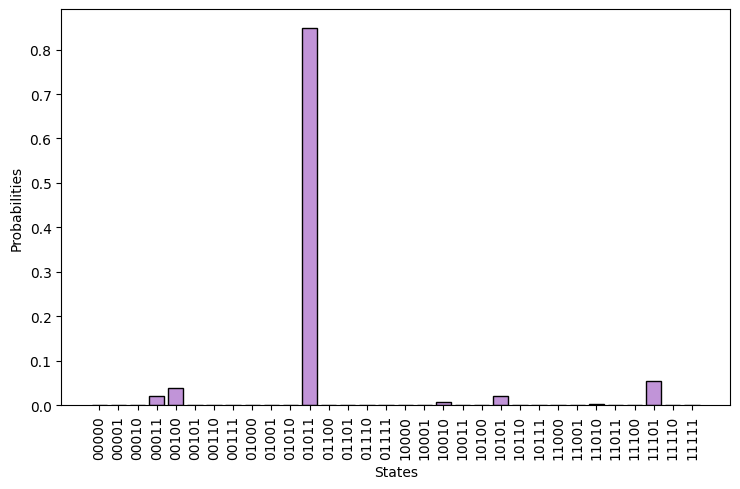

In [4]:
from qiboml.interfaces.pytorch import QuantumModel
from qibo.ui.result_visualization import visualize_state
import matplotlib.pyplot as plt

from qiboml.models.ansatze import HardwareEfficient
from qiboml.models.decoding import Expectation

# define the parametric parts 
circuit = HardwareEfficient(nqubits=nqubits, nlayers=3)
circuit_structure = [circuit,]
# define the decoding strategy
decoder = Expectation(
    nqubits=nqubits,
    observable=grover_hamiltonian(item_index, n_items), # this is the default choice anyway
)

# build your quantum model
model = QuantumModel(
   circuit_structure,
   decoder
)
model = model.to(dev)

# train the model
n_epochs = 20
energy_history = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
for epoch in range(n_epochs):
    optimizer.zero_grad()
    energy = model()
    energy.backward()
    optimizer.step()    
    print(f"Epoch {epoch}: Energy = {energy.item()}")
    # save the current energy
    energy = energy.item()
    energy_history.append(energy)

plt.plot(energy_history)
plt.ylabel("Energy")
plt.xlabel("Epoch")

# this is the item we were looking for
print(f"\n -> We were looking for item: {item_index:0{nqubits}b}")

# uncomment this to check which item your model found
# `circuit` should be the parametric circuit that you 
# built the QuantumModel with
visualize_state(circuit())


### Fetching multiple items

<div style="background-color: rgba(255, 105, 105, 0.3); border: 2.5px solid #000000; padding: 15px;">
    <strong>Exercise:</strong> 
    What if instead we wanted to retrieve multiple items at once?
</div>

**hint:**
<details>
    <summary>show</summary>
    In the multi-items case the energy landscape becomes way more rugged, thus a more careful tuning of the number of parameters of the circuit and number of epochs may be required...
</details>

In [5]:
item_indices = [31, 7, 16]
n_items = 32

# define a function that takes a list of indices, item_indices, and n_items
# as inputs and produces the Hamiltonian
def multi_grover_hamiltonian(item_indices: list[int], n_items: int) -> SymbolicHamiltonian:
    return sum(grover_hamiltonian(index, n_items) for index in item_indices)

Epoch 0: Energy = 0.9516363560165118
Epoch 10: Energy = -25.567354198285862
Epoch 20: Energy = -28.383865992300457
Epoch 30: Energy = -28.730326702390563
Epoch 40: Energy = -28.878216348841374
Epoch 50: Energy = -28.970413916004986
Epoch 60: Energy = -28.984754064026006
Epoch 70: Energy = -28.99529918615492
Epoch 80: Energy = -28.998488791384418
Epoch 90: Energy = -28.999279471373058
Epoch 100: Energy = -28.999722753367045
Epoch 110: Energy = -28.999879277123647
Epoch 120: Energy = -28.999931118748364
Epoch 130: Energy = -28.999964870702264
Epoch 140: Energy = -28.999978068696418
Epoch 150: Energy = -28.99998562553825
Epoch 160: Energy = -28.99999032296683
Epoch 170: Energy = -28.999993346682448
Epoch 180: Energy = -28.99999542813266
Epoch 190: Energy = -28.999996906326675

 -> We were looking for items: ['11111', '00111', '10000']


(<Axes: xlabel='States', ylabel='Probabilities'>,
 <Figure size 750x500 with 1 Axes>)

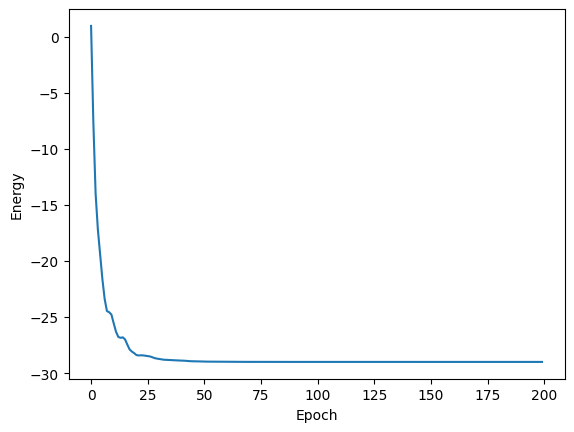

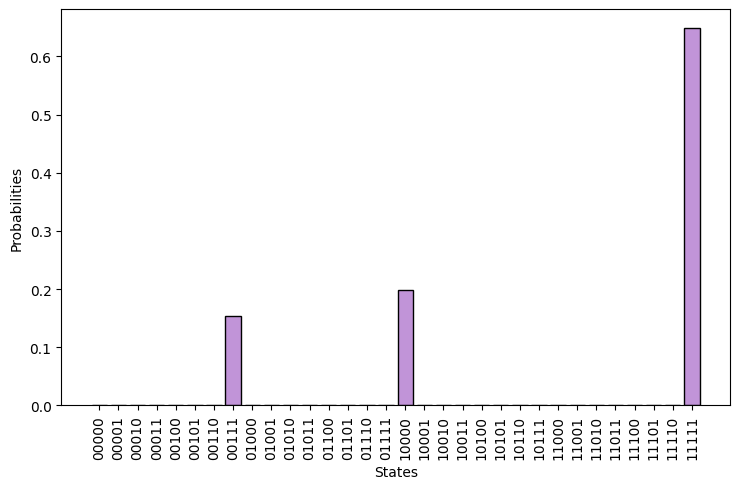

In [6]:
# define the parametric parts 
circuit = HardwareEfficient(nqubits=nqubits, nlayers=10)
circuit_structure = [circuit,]

# define the decoding strategy
decoder = Expectation(
    nqubits=nqubits,
    observable=multi_grover_hamiltonian(item_indices, n_items), # this is the default choice anyway
)

# build your quantum model
model = QuantumModel(
   circuit_structure,
   decoder
)
model = model.to(dev)

# train the model
n_epochs = 200
energy_history = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
for epoch in range(n_epochs):
    optimizer.zero_grad()
    energy = model()
    energy.backward()
    optimizer.step()    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Energy = {energy.item()}")
    # save the current energy
    energy = energy.item()
    energy_history.append(energy)

plt.plot(energy_history)
plt.ylabel("Energy")
plt.xlabel("Epoch")

# these are the items we were looking for
bitstrings = [f"{index:0{nqubits}b}" for index in item_indices]
print(f"\n -> We were looking for items: {bitstrings}")

# uncomment this to check which items your model found
# `circuit` should be the parametric circuit that you 
# built the QuantumModel with
visualize_state(circuit())

<div style="background-color: rgba(255, 105, 105, 0.3); border: 2.5px solid #000000; padding: 15px;">
    <strong>Exercise:</strong> Write a quantum circuit with 3 qubits to produce the states $|001\rangle$, $|010\rangle$, and $|111\rangle$.
    <br>
    ... but this time, using a single circuit!
    <br>
    For simplicity, let's say that we are not interested in obtaining specific amplitudes, but just a generic superposition of those 3 states:
    $$\alpha |001\rangle + \beta |010\rangle + \gamma |111\rangle $$
</div>

In [7]:
from qibo import Circuit

def superposition_preparation(state_indices: list[int], n_layers=2, n_epochs=200) -> Circuit:
    item_indices = state_indices
    nqubits = max(item_indices).bit_length()
    n_items = 2 ** nqubits

    # define the parametric parts 
    circuit = HardwareEfficient(nqubits=nqubits, nlayers=n_layers)
    circuit_structure = [circuit,]
    
    # define the decoding strategy
    decoder = Expectation(
        nqubits=nqubits,
        observable=multi_grover_hamiltonian(item_indices, n_items), # this is the default choice anyway
    )
    
    # build your quantum model
    model = QuantumModel(
       circuit_structure,
       decoder
    )
    model = model.to(dev)
    
    # train the model
    energy_history = []
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        energy = model()
        energy.backward()
        optimizer.step()    
        #if epoch % 10 == 0:
        #    print(f"Epoch {epoch}: Energy = {energy.item()}")
        # save the current energy
        energy = energy.item()
        energy_history.append(energy)
    
    #plt.plot(energy_history)
    #plt.ylabel("Energy")
    #plt.xlabel("Epoch")
    
    # these are the items we were looking for
    bitstrings = [f"{index:0{nqubits}b}" for index in item_indices]
    #print(f"\n -> We were looking for items: {bitstrings}")
    
    # uncomment this to check which items your model found
    # `circuit` should be the parametric circuit that you 
    # built the QuantumModel with
    #visualize_state(circuit())
    return circuit

(<Axes: xlabel='States', ylabel='Probabilities'>,
 <Figure size 600x500 with 1 Axes>)

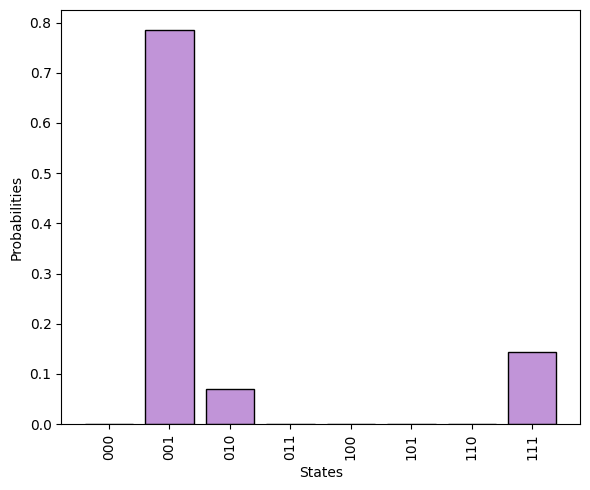

In [8]:
circuit = superposition_preparation([1,2,7])
visualize_state(circuit())

In [9]:
from qibo import gates

n_repetitions = 10
n_hits = 0
state_indices = [1,2,7]
bitstrings = [f"{index:0{3}b}" for index in state_indices]
for _ in range(n_repetitions):
    circuit = superposition_preparation(state_indices)
    circuit.add(gates.M(*range(3)))
    freq = circuit().frequencies()
    if len(freq) == 3 and all(bitstring in freq for bitstring in bitstrings):
        n_hits += 1

print(f"Superposition built {n_hits/n_repetitions * 100}% of the times")

Superposition built 60.0% of the times
